### Рассмотрим датасет "Стоимость страховки от параметров человека", в котором собраны данные о людях: age (возраст), sex (пол), bmi (индекс массы тела), children (количество детей), smoker (курящий человек или нет), region (регион), charges (стоимость страховки). Изначально классов нет, поэтому попробуем выделить определённые класстеры и попытаться понять, чем они характерны. После этого применим методы классификации.

Поля таблицы:
1.   age - Возраст
2.   sex - Пол
3.   bmi - Индекс массы тела
4.   children - Количество детей
5.   smoker - Курящий человек или нет
6.   region - Регион
7.   charges - Стоимость страховки




## Подключим необходимые библиотеки

In [238]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
import sklearn


## Загрузим датасет из csv файла

In [239]:
data = pd.read_csv('insurance.csv')
data.head()
print(len(data[data['smoker'] == 'no']))

1064


Посмотрим на некоторые данные из датасета

In [240]:
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


Проведём категоризацию признаков, для которых это необходимо

In [241]:
data['sex'] = data['sex'].astype('category')
data['smoker'] = data['smoker'].astype('category')
data['region'] = data['region'].astype('category')

## Визуализируем датасет

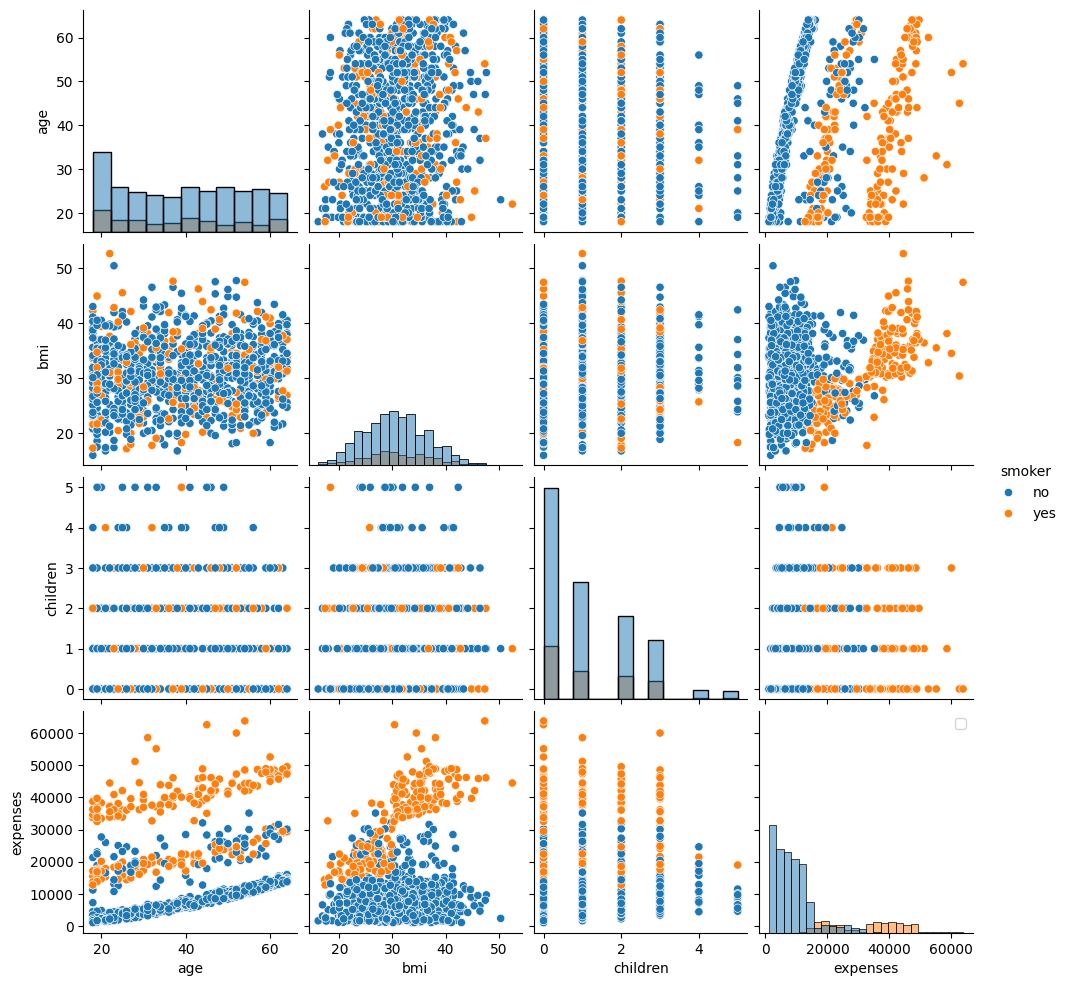

In [242]:
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
sns.pairplot(data.iloc[random_subset], hue = 'smoker', diag_kind='hist')
plt.legend()

### Вычислим основные характеристики

Построим матрицу корреляций

Факторизуем категориальные признаки

<Axes: >

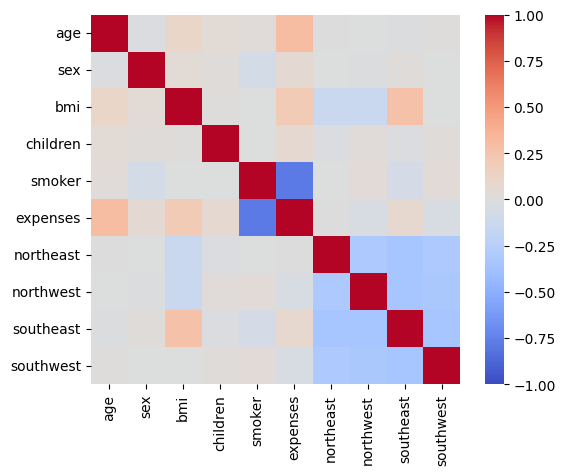

In [243]:
data['sex'] = pd.factorize(data['sex'])[0]
data['smoker'] = pd.factorize(data['smoker'])[0]
Region_dummies = pd.get_dummies(data['region'])
data = pd.concat((data, Region_dummies), axis=1)
data = data.drop(['region'], axis=1)

data.head()
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmin=-1)

Видно, что между признаками нет сильной корреляции

Посмотрим другие основные характеристики датасета: количество значений, среднее значение, стандартное отклонение, минимальное и максимальное значения, а также нижний и верхний квантили и медиану

In [244]:
data.describe()

,age,sex,bmi,children,smoker,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.665471,1.094918,0.795217,13270.422414
std,14.049960,0.500160,6.098382,1.205493,0.403694,12110.011240
min,18.000000,0.000000,16.000000,0.000000,0.000000,1121.870000
25%,27.000000,0.000000,26.300000,0.000000,1.000000,4740.287500
50%,39.000000,1.000000,30.400000,1.000000,1.000000,9382.030000
75%,51.000000,1.000000,34.700000,2.000000,1.000000,16639.915000
max,64.000000,1.000000,53.100000,5.000000,1.000000,63770.430000


## Предобработка перед кластеризацией

Посмотрим, имеются ли пропущенные занчения

In [245]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   sex        1338 non-null   int64  
 2   bmi        1338 non-null   float64
 3   children   1338 non-null   int64  
 4   smoker     1338 non-null   int64  
 5   expenses   1338 non-null   float64
 6   northeast  1338 non-null   bool   
 7   northwest  1338 non-null   bool   
 8   southeast  1338 non-null   bool   
 9   southwest  1338 non-null   bool   
dtypes: bool(4), float64(2), int64(4)
memory usage: 68.1 KB
None


Пропущенных значений нет

Нормализуем данные

In [246]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)

### Так как у нас нет решающего признака для тренировки классификатора, нам нужно его определить. Попробуем разбить наши данные на кластеры (labels)

# Разбиение на кластеры

По визуализации выше угадывается 3 кластера. Это подтверждается  использованием другого метода кластеризации

Другой метод кластеризации: BIRCH. Он удобен, так как работает по плотности и не требует предварительного предположения о числе кластеров.

In [247]:
from sklearn.cluster import Birch
model = Birch(threshold=0.3)
model.fit(data)

Birch(threshold=0.3)

Скопируем данные в новый датасет, чтобы не портить основной, и добавем столбец с признаком принадлежнасти к определённому кластеру

In [248]:
labels = pd.DataFrame({'labels':model.labels_})
data_new = data_stand
data_new = pd.concat((data_new, labels), axis=1)
data_new.head()

,age,sex,bmi,children,smoker,expenses,northeast,northwest,southeast,southwest,labels
0,-1.438227,-1.010141,-0.453476,-0.908274,-1.969850,0.298472,-0.565056,-0.566206,-0.611095,1.764821,2
1,-1.509401,0.989221,0.513994,-0.078738,0.507273,-0.953333,-0.565056,-0.566206,1.635183,-0.566206,0
2,-0.797655,0.989221,0.382811,1.580335,0.507273,-0.728402,-0.565056,-0.566206,1.635183,-0.566206,0
3,-0.441782,0.989221,-1.306161,-0.908274,0.507273,0.719574,-0.565056,1.764821,-0.611095,-0.566206,2
4,-0.512957,0.989221,-0.289498,-0.908274,0.507273,-0.776511,-0.565056,1.764821,-0.611095,-0.566206,0


Для понятной визуализации и проверки уберём регионы

In [249]:
data_new = data_new.drop(['northeast'], axis=1)
data_new = data_new.drop(['northwest'], axis=1)
data_new = data_new.drop(['southeast'], axis=1)
data_new = data_new.drop(['southwest'], axis=1)

Визуализируем полученный результат

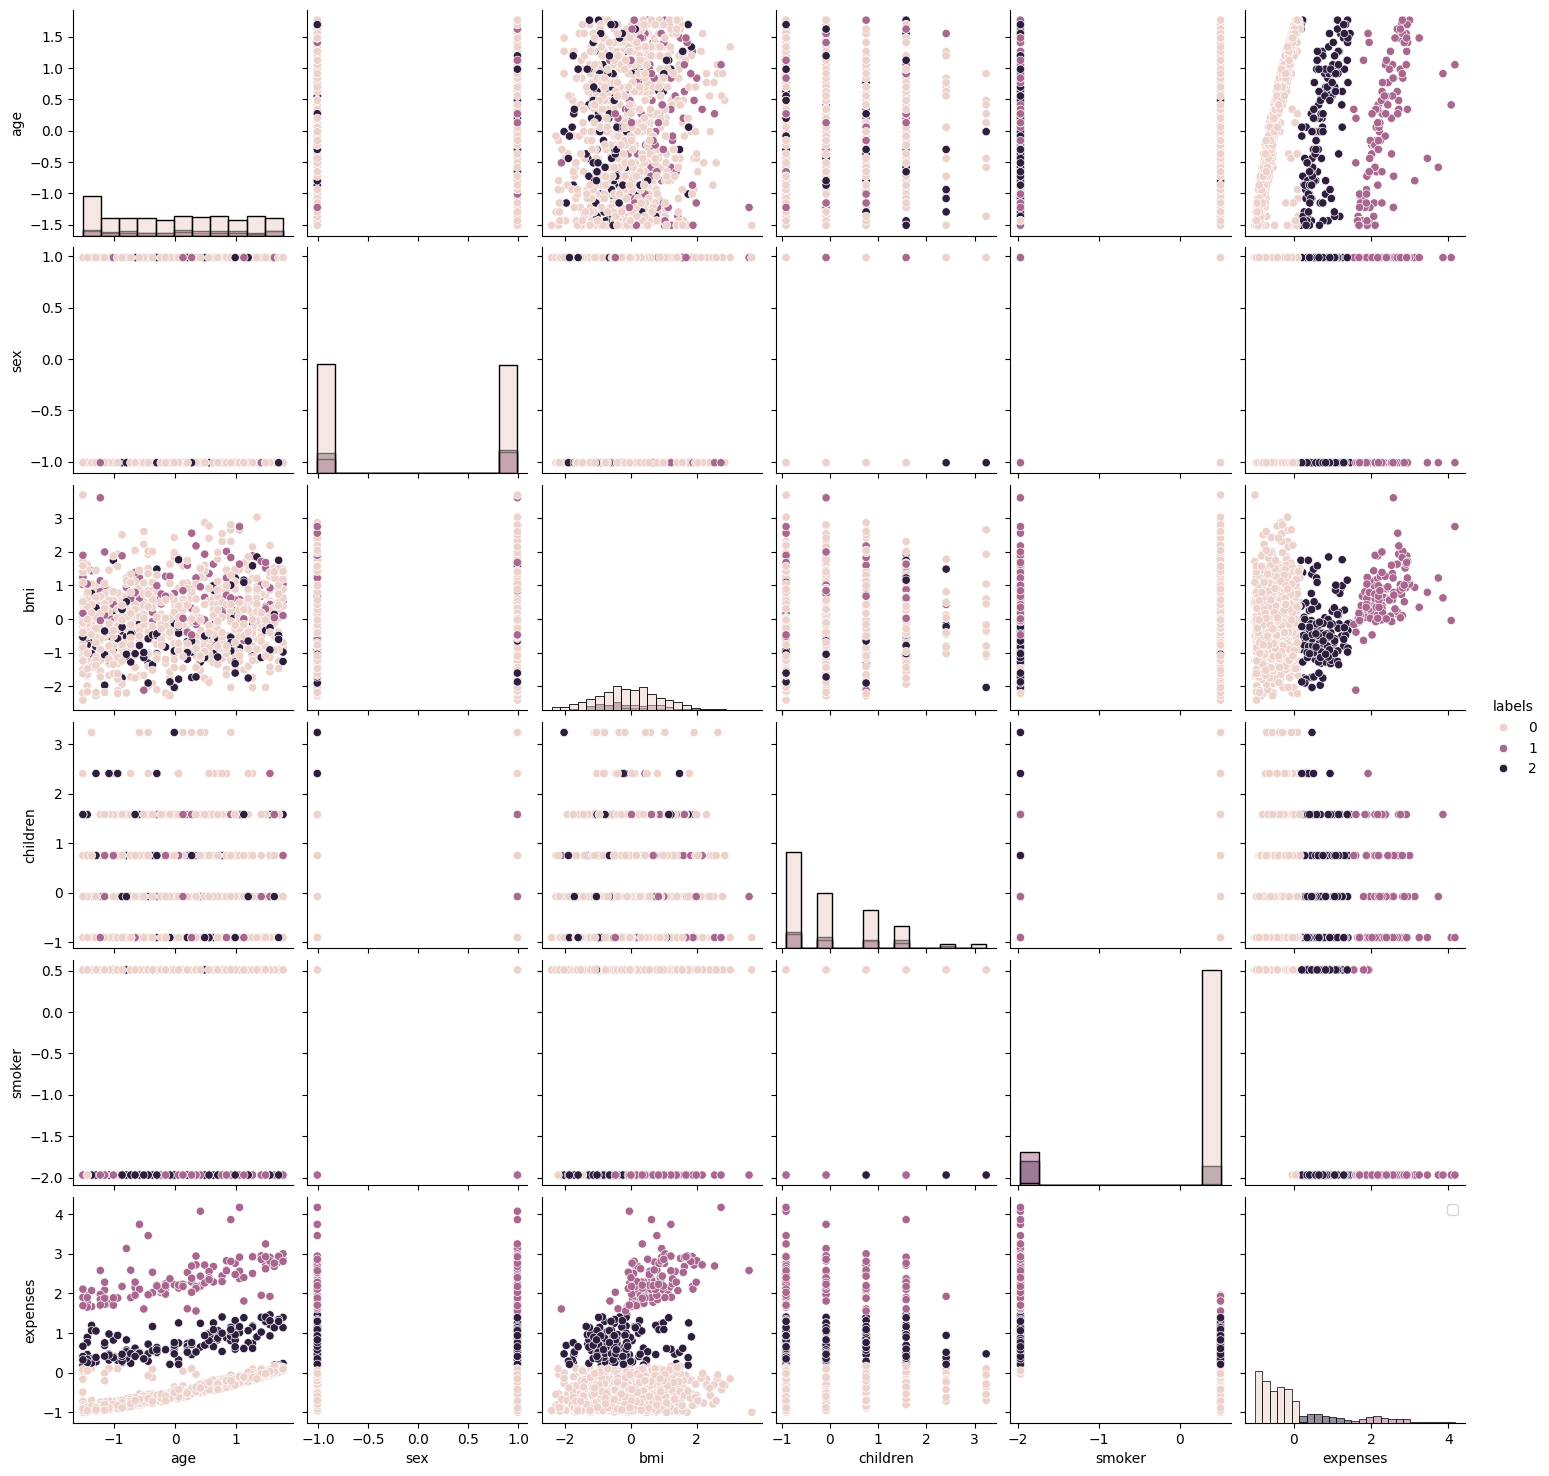

In [250]:
random_subset = np.random.choice(np.arange(data_new.shape[0]), size=1000, replace=False)
sns.pairplot(data_new.iloc[random_subset], hue = 'labels', diag_kind='hist' )
plt.legend()

Можно выделить 3 основных класса.

Предположительно:
1. Не курящие с хорошим индексом массы тела (bmi)
2. Курящие с нормальным индексом массы тела (bmi) или не курящие с плохим bmi
3. Курящие с плохим индексом массы тела (bmi)

Вернём регионы и посмотрим на корреляция для новых данных

expenses  labels      0.649747
smoker    labels     -0.678166
          expenses   -0.787251
dtype: float64

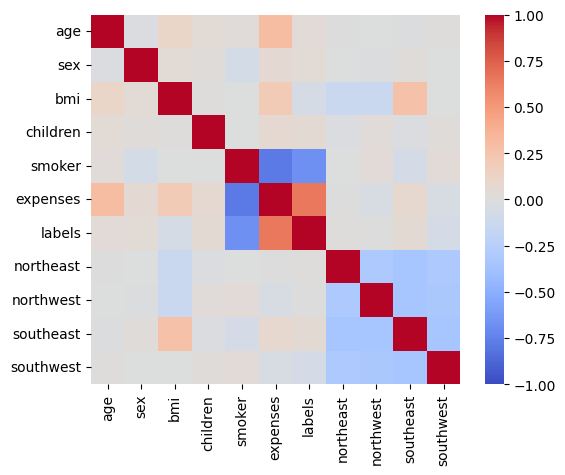

In [251]:
data_new = pd.concat((data_new, Region_dummies), axis=1)
corr_mat = data_new.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmin=-1)
corr_mat.where(np.triu(abs(corr_mat) > 0.5, k=1)).stack().sort_values(ascending=False)

Видна корреляция между:
1. Ценой страховки и привычкой курить
2. Ценой страховки и принадлежностью к определённому классу
3. Привычкой курить и принадлежностью к определенному классу?

Корреляция для первой группы:

Элементов в классе: 986


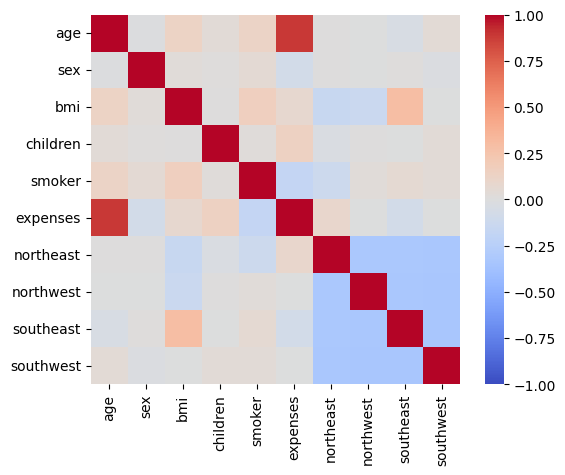

In [252]:
corr_mat = data_new[model.labels_ == 0].drop(['labels'], axis=1).corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmin=-1)
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)
print('Элементов в классе: '+str(len(data_new[model.labels_ == 0])))

В кластере 986 элементов

У этой группы основная корреляция стоимости страховки и возраста

Корреляция для второй группы

Элементов в классе: 156


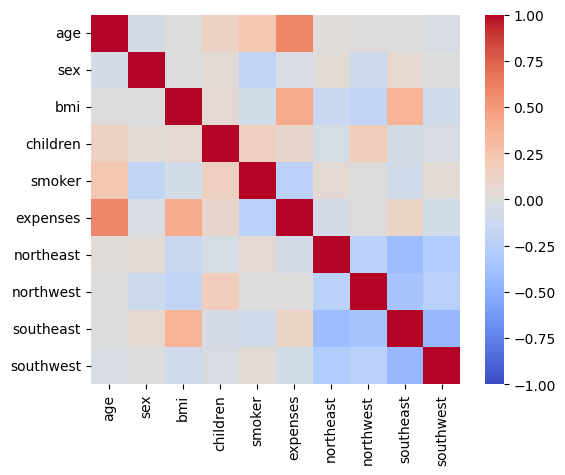

In [253]:
corr_mat = data_new[model.labels_ == 1].drop(['labels'], axis=1).corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmin=-1)
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)
print('Элементов в классе: '+str(len(data_new[model.labels_ == 1])))

В кластере 156 элементов

У этой группы заметна корреляция стоимости страховки от возраста и bmi

Корреляция для третьей группы

Элементов в классе: 196


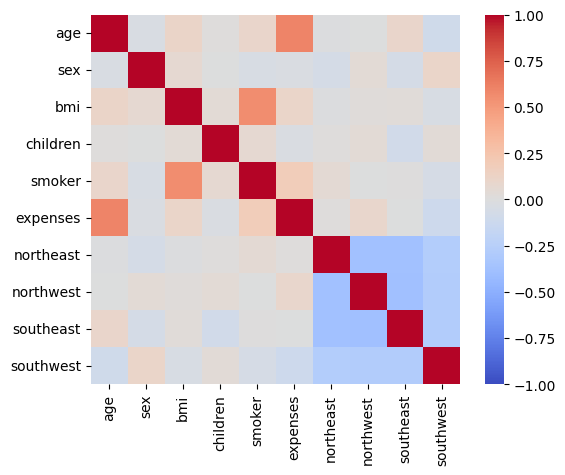

In [254]:
corr_mat = data_new[model.labels_ == 2].drop(['labels'], axis=1).corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm',vmin=-1)
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)
print('Элементов в классе: '+str(len(data_new[model.labels_ == 2])))

В кластере 196 элементов

У этой группы видна корреляция стоимости страховки от возраста и bmi, и bmi от курения ???

По корреляции видно, что наши предположения по классам верны. Отсутствует заметная корреляции между регионом и другими параметрами, поэтому в дальнейшем их можно убрать из рассмотрения, когда будем использовать линейную регрессию внутри кластеров. Также видна несбалансированность полученных кластеров (первый больше второго и третьего).

Теперь у нас есть решающий параметр labels - класс, к которому принадлежит объект. Мы можем применить алгоритм классификации k- ближайших соседей.

## Создаём классификатор

Разобьём данные на тренировочную и тестовую выборки

In [255]:
X = data_new.drop('labels', axis = 1)
y = data_new['labels']

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(len(X_train))
print(len(X_train_balanced))

936
2049


## Пробуем kNN
Также поборемся с несбалансированностью классов, дополняя миноритарные классы случайными элементами, подходящими под параметры класса

С 1 соседом

In [256]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier(n_neighbors=1)

In [257]:
y_test_predict = knn.predict(X_test)
y_train_predict = knn.predict(X_train_balanced)

Посмотрим на ошибку и матрицу путаницы на тренировочной выборке

In [258]:
err_train  = np.mean(y_train_balanced  != y_train_predict)
err_train

0.0

In [259]:
confusion_matrix(y_train_balanced, y_train_predict)

array([[683,   0,   0],
       [  0, 683,   0],
       [  0,   0, 683]])

Посмотрим на ошибку и матрицу путаницы на тестовой выборке

In [260]:
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.024875621890547265

In [261]:
confusion_matrix(y_test, y_test_predict)

array([[302,   0,   1],
       [  0,  46,   1],
       [  7,   1,  44]])

Видим довольно хорошие результаты

Посмотрим какое колличество соседей будет оптимальным

In [262]:
error_rates = []
for i in np.arange(1, 30):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(X_train, y_train)
    new_predictions = new_model.predict(X_test)
    error_rates.append(np.mean(new_predictions != y_test))

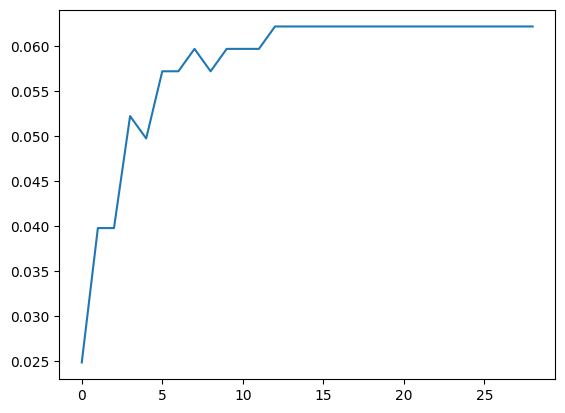

In [263]:
plt.plot(error_rates)

Лучший результат достигается при k=1

# Logistic

In [264]:
from sklearn.linear_model import LogisticRegression

knn = LogisticRegression()
knn.fit(X_train, y_train)

LogisticRegression()

In [265]:
y_test_predict = knn.predict(X_test)
y_train_predict = knn.predict(X_train)


Посмотрим на ошибку и матрицу путаницы на тренировочной выборке

In [266]:
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.014957264957264958

In [267]:
confusion_matrix(y_train, y_train_predict)

array([[680,   0,   3],
       [  0, 105,   4],
       [  7,   0, 137]])

Посмотрим на ошибку и матрицу путаницы на тестовой выборке

In [268]:
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.014925373134328358

In [269]:
confusion_matrix(y_test, y_test_predict)

array([[301,   0,   2],
       [  0,  45,   2],
       [  2,   0,  50]])

### Разница работы k-ближайших соседей и Logictic на данном датасете не велика, но на тестовой выборке ошибка Logictic меньше.

#Теперь попробуем использовать Random forest


In [270]:
from types import new_class
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=3)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=3)

In [271]:
from sklearn.metrics import rand_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_labeles = rfc.predict(X_test)
cm = confusion_matrix(y_test, pred_labeles)
rand_s = rand_score(y_test, pred_labeles)
print('Оценка RAND: ', rand_s)

Оценка RAND:  1.0


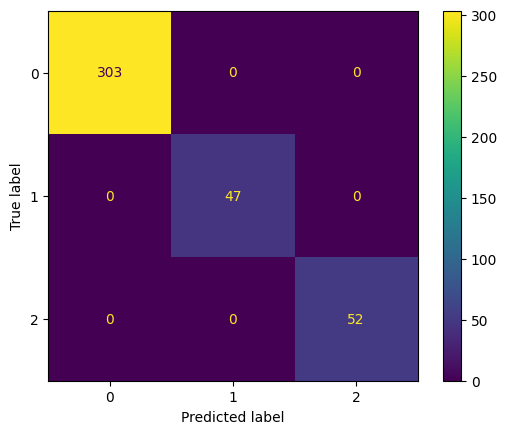

In [272]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
ConfusionMatrixDisplay(cm)
pass

##Лучший результат показал Random  Forest

## Применим линейную регрессию для полученных кластеров

Предсказание цены страховки для человека, по его параметрам и принадлежности к определённому классу

In [273]:
#Убираем регионы
data = data.drop(['northeast'], axis=1)
data = data.drop(['northwest'], axis=1)
data = data.drop(['southeast'], axis=1)
data = data.drop(['southwest'], axis=1)
data = data.drop(['children'], axis=1)

In [274]:
data.head()

,age,sex,bmi,smoker,expenses
0,19,0,27.9,0,16884.92
1,18,1,33.8,1,1725.55
2,28,1,33.0,1,4449.46
3,33,1,22.7,1,21984.47
4,32,1,28.9,1,3866.86


Предсказываем цену для первого класса

Для этого класса можно было бы оставить зависимоть только цены от возроста, но я решил так не делать и попробовать сделать LR для выех параметров

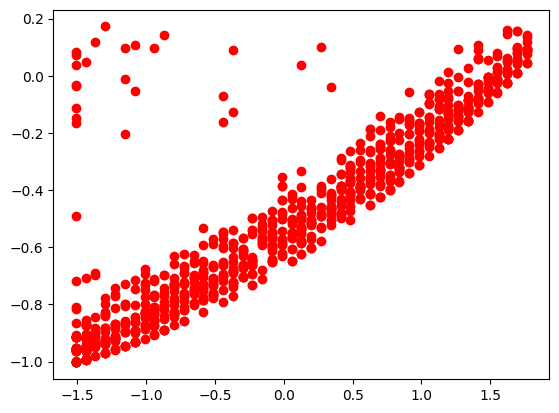

In [275]:
from sklearn.model_selection import train_test_split

data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)

data_lr = pd.concat((data_stand, labels), axis=1)
data_lr = data_lr[data_lr['labels'] == 0]

#X = data_lr.drop(['charges','labels','sex','bmi','smoker'], axis=1)
X = data_lr.drop(['expenses','labels'], axis=1)
y = data_lr['expenses']

plt.scatter(X['age'],y, color="red")
#Визуализация для проверки правильно ли выбран класс
#Сверху слева НЕ выбросы - это молодые люди с хорошим bmi и логично,
#что их страховка стоит примерно столько же сколько и пожилых но с хорошим bmi

Визуализация для проверки правильно ли выбран класс

Отдельные точки верху слева не выбросы - это молодые люди с хорошим bmi, их страховка стоит примерно столько же, сколько у пожилых людей с хорошим bmi

In [276]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 39)

In [277]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [278]:
y_train_predict = lr_model.predict(X_train)
y_test_predict  = lr_model.predict(X_test)

In [279]:
print(lr_model.coef_)
print(lr_model.intercept_)

[ 0.29513245 -0.01843155 -0.0005942  -0.39098166]
-0.31108322308193814


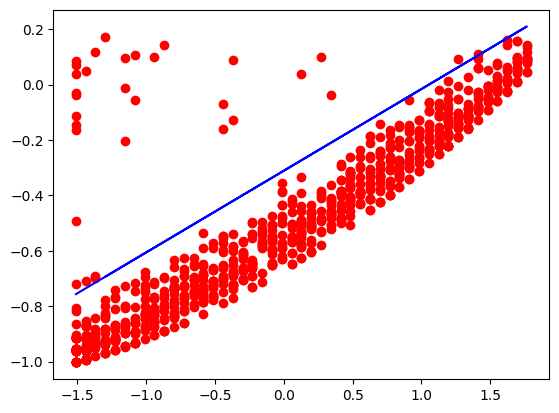

In [280]:
plt.scatter(X['age'],y, color="red")
plt.plot(X['age'],lr_model.coef_[0]*X['age'] + lr_model.intercept_, color='blue' )

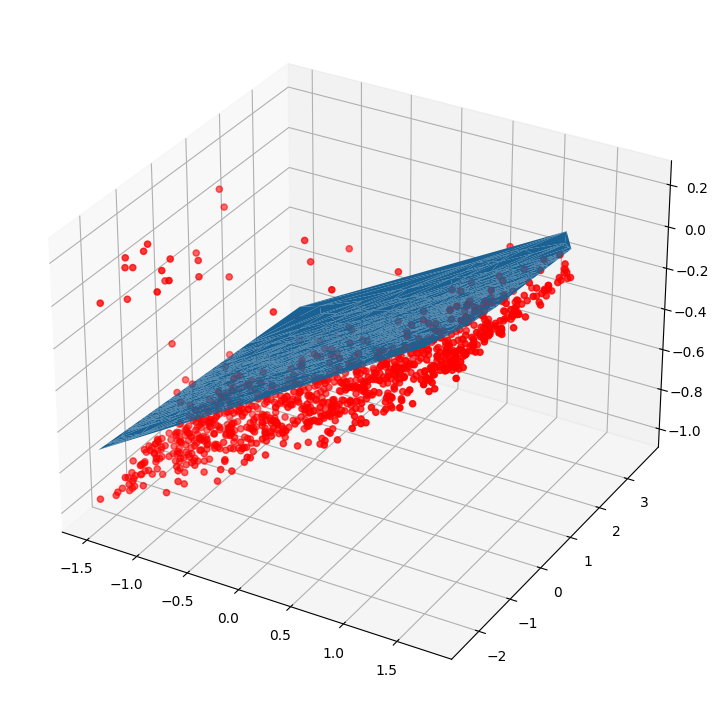

In [281]:
# plt.plot(X['age'],lr_model.coef_[0]*X['age'] + lr_model.intercept_, color='red' )
x_ = np.array(X['age'])
y_ = np.array(X['bmi'])
z_ = np.array(x_*lr_model.coef_[0] + y_*lr_model.coef_[1] + lr_model.intercept_)

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(X['age'],X['bmi'],y, color='red')

# Creating plot
ax.plot_trisurf(x_, y_, z_)

## Нам не нужно исключать коррелированные переменные, так как отсутсвует сильная зависимость между ними, поэтому исключение может повлиять на результат только негативным образом, мы утратим нужную информацию.